In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np

from sklearn import set_config ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO
set_config(display = 'diagram') ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, cohen_kappa_score, accuracy_score, confusion_matrix, precision_score, recall_score
from  sklearn.base import clone ## Copiar un pipeline
import xgboost as xgb

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings("ignore")


In [3]:
! python --version

Python 3.11.5


In [5]:
train = pd.read_csv('Train.csv')

In [6]:
train.head(2)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [8]:
## Realizamos una copia del dataset original en caso de volver a ocupar esta versión sin cambios.
train_original = train.copy()

In [ ]:
## Se verifica si hay datos duplicados
train.loc[train.duplicated()]

In [9]:
## Se elimina la variable ID, no es relevante para el análisis
train.drop('ID', axis = 1, inplace = True)

## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

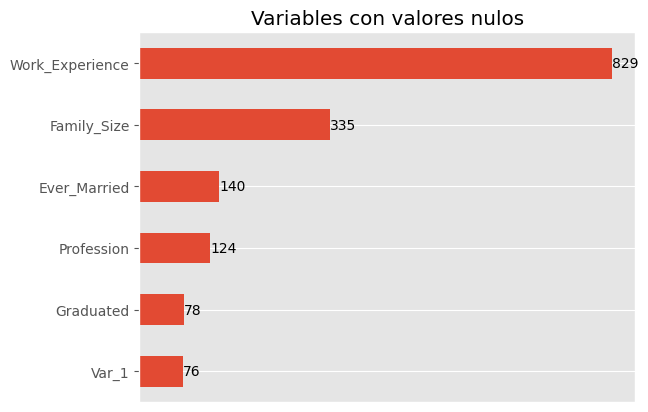

In [10]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [ ]:
train.isnull().sum(axis = 1).value_counts()

* En el control de calidad de los datos, se encuentra que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto a el número de nulos por observación se encuentra que, existen 6.665 registros completos, 1.244 registros con un dato faltante en 1 columna, 140 registros con datos faltantes en 2 columnas y 19 registros con al menos 3 columnas sin dato.

In [11]:
## Se define la función para separar las variables categóricas, numéricas y la independiente
def SepararNumCate(df : pd.DataFrame):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    categorical = df.select_dtypes(exclude = 'number').columns.to_list()
    categorical.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = ['Segmentation']
    return numerical, categorical, target


num_idx, categ_idx, target_idx = SepararNumCate(train)

In [12]:
## Identificar los valores únicos de las variables categóricas
for i in train[categ_idx + target_idx].columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Categorías de la variable "Gender"  ['Male' 'Female'] 

Categorías de la variable "Ever_Married"  ['No' 'Yes' nan] 

Categorías de la variable "Graduated"  ['No' 'Yes' nan] 

Categorías de la variable "Profession"  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Categorías de la variable "Spending_Score"  ['Low' 'Average' 'High'] 

Categorías de la variable "Var_1"  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Categorías de la variable "Segmentation"  ['D' 'A' 'B' 'C'] 



Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias que se pondrán a prueba:

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor del dato, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asigna el valor de los datos por algún método de imputación.


**Se define los pipelines y la función por la cual va a pasar cada uno de los dataset de las anteriores estrategias**

In [13]:
### Pipelines

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )

rf_model = RandomForestClassifier(random_state = 123)
lr_model = LogisticRegression(random_state = 123)
nb_model = GaussianNB()
kn_clf_model = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier(random_state = 123)


### Diccionario que contiene todos los pipelines
pl_dict = { 'RandomForest' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',rf_model)
                                        ]),
            'LogisticRegression' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',lr_model)
                                        ]),
            'NaiveBayes' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',nb_model)
                                         ]),
            'KNeighborsClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',kn_clf_model)
                                         ]),
            'XGBClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',xgb_clf)
                                         ])                                         
           }

## Crear el pipeline para la imputación
num_imputer = Pipeline(steps = [
        ('num_imputer',SimpleImputer(strategy = 'median')),
])

cat_imputer = Pipeline(steps = [
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent'))
])

columnImputer = ColumnTransformer(transformers = [
    ('Numerical',num_imputer,num_idx),
    ('Categorical', cat_imputer, categ_idx)
                                ], 
            remainder = 'passthrough' ## En este caso no se utiliza el passthrough porque necesitamos nuestra variable objetivo, ya que este pipeline es sólo para transformar columna
)

imputer_pipe = Pipeline(steps=[
    ('columns_transf',columnImputer)
])

def ImputersTest(df : pd.DataFrame,  numerical_columns : list, 
                 categorical_columns : list, target : str, model : str): 
    if model in pl_dict.keys():
        pipe = clone(pl_dict.get(model))
        print(f"Accuracy with CV : {cross_val_score(pipe,df[numerical_columns + categorical_columns], df[target], cv = 5, scoring = 'accuracy').mean()}")
        return None
    else:
        print(f'{model} no es un modelo implementado, las opciones son {list(pl_dict.keys())}')

### Estrategia 1

No hacer ningún tratamiento de imputación, se eliminan las filas que contengan NA's.

In [14]:
train1 = train.dropna( axis = 0).copy()

In [15]:
ImputersTest(train1 ,num_idx, categ_idx, target_idx, 'RandomForest')

Accuracy with CV : 0.48012003000750186


### Estrategia 2

In [16]:
## Se eliminan las filas que tienen datos faltantes en 2 o más de sus columnas
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

In [17]:
train2_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train2), columns = num_idx + categ_idx + target_idx)

In [18]:
ImputersTest(train2_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.48173082535897604


### Estrategia 3

In [19]:
train3 = train.copy()

In [20]:
train3_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train3), columns = num_idx + categ_idx + target_idx)

In [21]:
ImputersTest(train3_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.476822763620552


De las 3 estrategias propuestas y evaluadas, todas presentaron un accuracy similar, No obstante si se eliminan todos los datos faltantes (estrategia 1) se perdería alrededor del 17% de las observaciones, mientras que si se eliminan sólo aquellos registros cuyas observaciones tengan nulos en 2 o más variables se perdería alrededor del 2% del dataset original. Por lo cual, se realizará el resto del ejercicio con el dataset derivado de la estrategia 2.

In [22]:
## Definimos el dataset imputado para seguir trabajando el resto del ejercicio
del train ## se elimina el df que tenía este nombre

train = train2_imp.copy().astype(train1.dtypes.to_dict()) ## Se le asignan el tipo de variables de uno de los datasets ya que con la imputación todas las variables quedan como tipo object.


### b. Visualización de la información

* **Balanceo de la variable dependiente**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

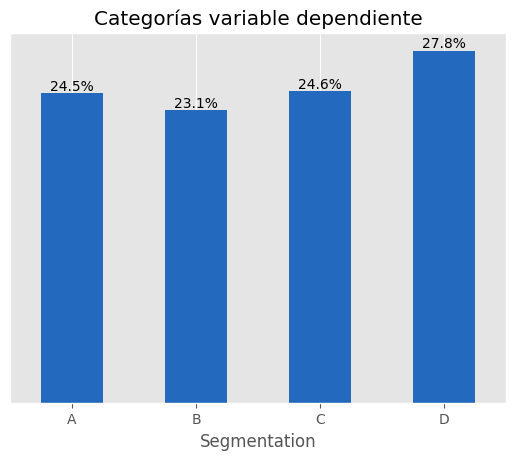

In [36]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar',colormap= 'vlag')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis='x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax.set_title("Categorías variable dependiente")
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

# Descripción variable numéricas vs variable dependiente

En la siguiente figura se encuentra la distribución de las variable numéricas independientes en terminos de la variable "Segementation" que es la variable dependiente. De izquierda a derecha se encuentral la Edad, en la parte central la experencia laboral y en la zona derecha el tamaño de la familia.

* **Segmentación vs Edad:**

    En este gráfico el grupo D, tiene en promedio una edad menor que el resto de grupos, 32 años. Sin embargo, es el grupo con mayor asimetría en la distribucción de la variable "Age". Los 3 grupos restantes tienen una edad promedio muy cercana a los 50 años.

* **Segmentación vs Experiencia laboral**

    En cuanto la distribución de la variable  "Work experience", para todas las categorías de Segmentation se encuentra que el promedio esta entre los 2 y 3 años. Sin embargo, es el grupo **D** el de mayor promedio y  también es posible identificar que los registros en esta grupo son los quee más experiencia tiene puesto que un 75% de los individuos tienen una experiencia laboral de 6 años o menos, y el grupo **C** es el que menos experiencia tiene ya que el $75%$ de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

  El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas, por otra parte el núcleo familiar del Segmento A es más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

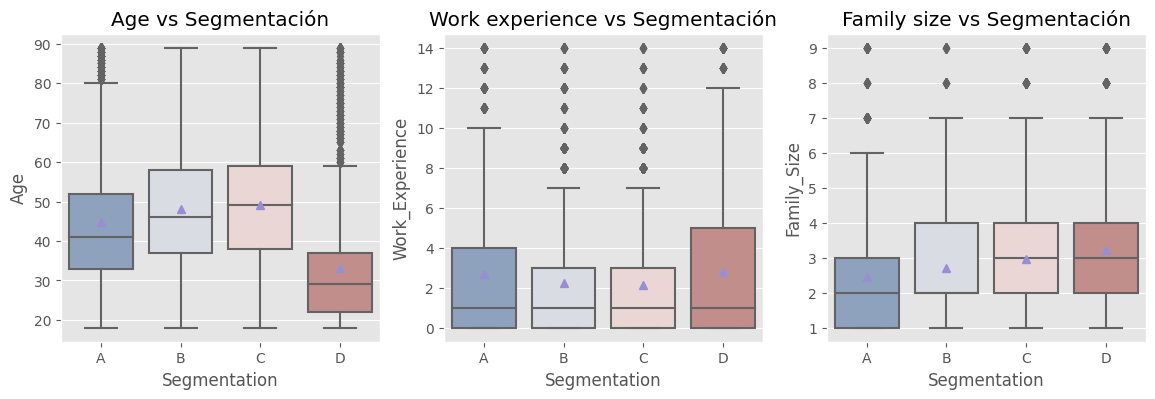

In [28]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
sns.boxplot(data = train, x = 'Segmentation', y = 'Age',order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True, palette = 'vlag').set(title='Age vs Segmentación')
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag").set(title='Work experience vs Segmentación')
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag").set(title='Family size vs Segmentación')

#//TODO ...poner la media como texto en cada uno de los boxplots
# Calcular la media por categoría
# means = train.groupby('Segmentation')[['Age', 'Work_Experience', 'Family_Size']].mean().values

# Agregar líneas para la media y la mediana
#for i in range(len(train.Segmentation.sort_values().unique())):
 #   plt.text(i, means[i], f'{means[i]:.2f}', ha='center', va='bottom', color='blue', fontsize=8)

plt.show()


* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación elos grupos A y B alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  
* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó sigue el comportamiento siguiente diferenciándola por la Segmentación: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.

* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C  predomina el consumo promedio con un poco más del 40%.

* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40% seguido por los doctores y profesionales del entretenamiento.
     
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y más del 50% en el grupo D

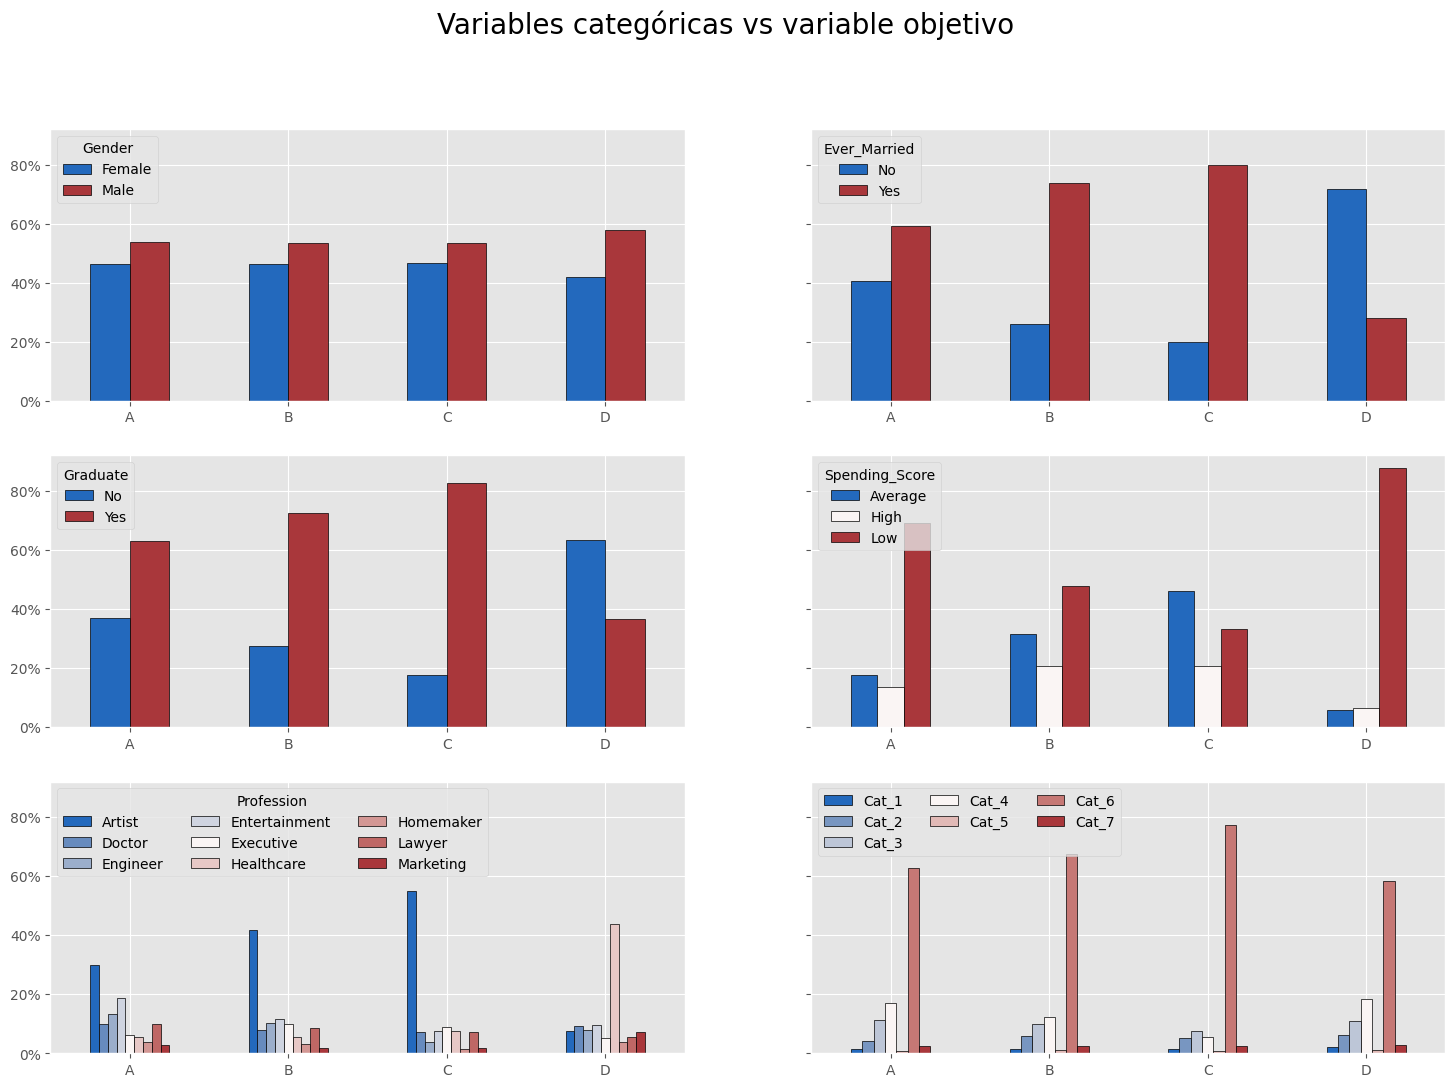

In [32]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3,2, figsize = (18,12), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black',colormap= 'vlag')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')
ax1.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black', colormap= 'vlag')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left',  title = 'Ever_Married')
ax2.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax3, edgecolor = 'black',colormap= 'vlag')
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax3.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax3.legend(loc = 'upper left', title = 'Graduate')
ax3.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax4, edgecolor = 'black',colormap= 'vlag')
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax4.tick_params(axis='x', rotation = 0) 
ax4.legend(loc = 'upper left', title = 'Spending_Score')
ax4.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax5, edgecolor = 'black',colormap= 'vlag')
ax5.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax5.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax5.legend(loc = 'upper left', ncols = 3, title = 'Profession')
ax5.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax6, edgecolor = 'black',colormap= 'vlag')
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax6.tick_params(axis='x', rotation=0) 
ax6.legend(loc = 'upper left', ncols = 3)
ax6.set_xlabel(None)
fig.suptitle('Variables categóricas vs variable objetivo', fontsize = 20)
plt.show()

### Coeficiente de contigencia

Con el coeficiente de conteigencia se busca ver el grado de asociación entre las variables categóricas  nominales u ordinales del data set con la variable dependiente **\"Segmentation"**

In [34]:
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

**Interpretación asociación entre variables categóricas independientes y variable objetivo**
 - Todas las variables tienen un coeficiente menor a 0.6, por lo que ninguna presenta una asociación relativamente intensa con la variable objetivo. Sin embargo, la variable Ever_Married es la que mayor coeficiente de asociación tiene con un coeficiente de 0.42.


In [35]:
calcular_coeficiente_contingencia(train1,categ_idx, 'Segmentation')

,Variable,Coeficiente de Contingencia
0,Ever_Married,0.4275
1,Graduated,0.3711
2,Profession,0.3387
3,Spending_Score,0.3175
4,Var_1,0.1015
5,Gender,0.0460


### c. Extracción de información de los datos

### d. Comprensión y limpieza de datos


In [ ]:
##  //TODO ...SE DEBERÍAN ELIMINAR LOS OUTLIERS  ??

### e. Entrenar el modelo de clasificación

In [49]:
## Definir protocolos de evaluación
def ClfScores(model, x_train,y_train,x_test,y_test):
    '''
    model : must be a previously fitted estimator
    '''
    yTest_pred = model.predict(x_test)
    yTrain_pred = model.predict(x_train)
    acc_test = accuracy_score(y_test, yTest_pred)
    acc_train = accuracy_score(y_train, yTrain_pred)
    ck_train = cohen_kappa_score(y_train, yTrain_pred)
    ck_test = cohen_kappa_score(y_test, yTest_pred)
    precision_train = precision_score(y_train, yTrain_pred, average = None)
    precision_test = precision_score(y_test, yTest_pred, average = None)
    rec_train = recall_score(y_train, yTrain_pred, average = None)
    rec_test = recall_score(y_test, yTest_pred, average = None)
    metrics = {
                'Accuracy test' : acc_test,
                'Accuracy train' : acc_train,
                'Cohen Kappa train' :  ck_train,
                'Cohen Kappa test' :  ck_test,
                'Precision train' : precision_train,
                'Precision test' : precision_test,
                'Recall train' :  rec_train,
                'Recall test'  :  rec_test
    }
    for i in metrics.keys():
        print(i,' : ', metrics.get(i))
    return None

Cargar los datos de test y realizar proceso de transformación e imputación

In [50]:
df_test = pd.read_csv("Test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
 10  Segmentation     2627 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 225.9+ KB


In [51]:
## Se verifica si hay datos duplicados
df_test.loc[df_test.duplicated()]
## Se elimina la variable ID, no es relevante para el análisis
df_test.drop('ID', axis = 1, inplace = True)

In [52]:
# Separar el data set de test con la función
num_idx_test, categ_idx_test, target_idx_test = SepararNumCate(df_test)

In [53]:
# Usar el pipeline de  imputación y transformación 
test_clean = pd.DataFrame(clone(imputer_pipe).fit_transform(df_test), columns = num_idx_test + categ_idx_test + target_idx_test)

In [54]:
## HoldOut
X_train = train[num_idx + categ_idx]
y_train = train[target_idx]
X_test = test_clean[num_idx_test + categ_idx_test]
y_test = test_clean[target_idx_test]


In [55]:
target_transf = LabelEncoder()  ## Es necesario etiquetar la variable objetivo, algunos algoritmos lo requieren (XGBClassifier)
y_train = target_transf.fit_transform(y_train)
y_test = target_transf.transform(y_test)

In [56]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [57]:
ClfScores(dummy_clf,X_train, y_train, X_test, y_test)

Accuracy test  :  0.28892272554244386
Accuracy train  :  0.27803767859400685
Cohen Kappa train  :  0.0
Cohen Kappa test  :  0.0
Precision train  :  [0.         0.         0.         0.27803768]
Precision test  :  [0.         0.         0.         0.28892273]
Recall train  :  [0. 0. 0. 1.]
Recall test  :  [0. 0. 0. 1.]


#### Selección de variables



In [62]:
# Selección de características
# Podemos utilizar un método diferente para la selección de características
# En este caso hacemos uso de SelectKBest que nos permite seleccionar las k mejores variables
# independientes teniendo en cuenta el f_classif 
# Construimos una función que a partir del conjunto de entrenamiento y el de prueba nos retorna
# los conjuntos ya transformados


 
def select_features(X_train, y_train, X_test,n):
  fs = SelectKBest(score_func=f_classif, k=n)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              7909 non-null   int64  
 1   Work_Experience  7909 non-null   float64
 2   Family_Size      7909 non-null   float64
 3   Gender           7909 non-null   object 
 4   Ever_Married     7909 non-null   object 
 5   Graduated        7909 non-null   object 
 6   Profession       7909 non-null   object 
 7   Spending_Score   7909 non-null   object 
 8   Var_1            7909 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 556.2+ KB


**Pipelines modelos**

In [21]:
## Grid parameters for each of the models
rf_grid_params = { 'model__max_depth': [1,4,8,12],
                'model__max_features': ['sqrt'],
                'model__max_leaf_nodes': [2,4,6,8],
                'model__min_samples_leaf': [5,10,20],
                'model__min_samples_split': [2, 5, 10],
                'model__n_estimators': [100,200]}

nb_grid_params = {'model__var_smoothing': np.logspace(0,-9, num = 100)}

kn_grid_params = {'model__n_neighbors' : np.arange(1,30)}

xgb_grid_params = {'model__learning_rate': [0.03,0.3],
                  'model__subsample'    : [1, 0.5, 0.2],
                  'model__n_estimators' : [100,500,1000],
                  'model__max_depth'    : [None,5,7,12] }

In [22]:
## RandomForest
rf_gs = GridSearchCV(clone(pl_dict.get('RandomForest')), rf_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
rf_gs.fit(X_train, y_train)
rf_model = clone(pl_dict.get('RandomForest')).set_params(**rf_gs.best_params_)
rf_model.fit(X_train, y_train)
ClfScores(rf_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.4936788874841972
Accuracy train  :  0.510826616089774
Cohen Kappa train  :  0.3425257985244785
Cohen Kappa test  :  0.3224103966992705
Precision train  :  [0.41510695 0.40031153 0.51292247 0.60725769]
Precision test  :  [0.43342776 0.36129032 0.49494949 0.56476684]
Recall train  :  [0.40403383 0.17760885 0.65774379 0.74520857]
Recall test  :  [0.38345865 0.14698163 0.64986737 0.76941176]


In [23]:
## LogisticRegression
lr_model = clone(pl_dict.get('LogisticRegression'))
lr_model.fit(X_train, y_train)
ClfScores(lr_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.5139064475347661
Accuracy train  :  0.5158843053579896
Cohen Kappa train  :  0.3510956530147953
Cohen Kappa test  :  0.3503694147248987
Precision train  :  [0.41864407 0.40755208 0.51560021 0.65068493]
Precision test  :  [0.43678161 0.40104167 0.50425532 0.6371134 ]
Recall train  :  [0.482108   0.21630961 0.62141491 0.69616685]
Recall test  :  [0.47619048 0.20209974 0.62864721 0.72705882]


In [24]:
## NaiveBayes
nb_gs = GridSearchCV(clone(pl_dict.get('NaiveBayes')), nb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
nb_gs.fit(X_train, y_train)
nb_model = clone(pl_dict.get('NaiveBayes')).set_params(**nb_gs.best_params_)
nb_model.fit(X_train, y_train)
ClfScores(nb_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.4949431099873578
Accuracy train  :  0.49865655128813025
Cohen Kappa train  :  0.32722667696659846
Cohen Kappa test  :  0.32554627839174954
Precision train  :  [0.44932432 0.38042131 0.46065013 0.62012012]
Precision test  :  [0.48122867 0.39215686 0.45053004 0.59152216]
Recall train  :  [0.34612882 0.2121631  0.68642447 0.69842165]
Recall test  :  [0.35338346 0.20997375 0.67639257 0.72235294]


In [25]:
## KNeighborsClassifier
kn_gs = GridSearchCV(clone(pl_dict.get('KNeighborsClassifier')), kn_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
kn_gs.fit(X_train, y_train)
kn_model = clone(pl_dict.get('KNeighborsClassifier')).set_params(**kn_gs.best_params_)
kn_model.fit(X_train, y_train)
ClfScores(kn_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.5075853350189633
Accuracy train  :  0.5509720246562352
Cohen Kappa train  :  0.3988212352243863
Cohen Kappa test  :  0.34210647132367944
Precision train  :  [0.48389218 0.44579358 0.56030006 0.65885417]
Precision test  :  [0.44390244 0.37984496 0.52764977 0.6125    ]
Recall train  :  [0.47885491 0.35521769 0.61886552 0.71307779]
Recall test  :  [0.45614035 0.25721785 0.60742706 0.69176471]


In [26]:
## XGBClassifier
xgb_gs = GridSearchCV(clone(pl_dict.get('XGBClassifier')), xgb_grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
xgb_gs.fit(X_train, y_train)
xgb_model = clone(pl_dict.get('XGBClassifier')).set_params(**xgb_gs.best_params_)
xgb_model.fit(X_train, y_train)
ClfScores(xgb_model,X_train, y_train, X_test, y_test)

Accuracy test  :  0.5372945638432364
Accuracy train  :  0.6108740319266635
Cohen Kappa train  :  0.47835166338454294
Cohen Kappa test  :  0.3811700026505467
Precision train  :  [0.54285714 0.56262231 0.62348668 0.6784141 ]
Precision test  :  [0.48129676 0.41791045 0.56153846 0.62332696]
Recall train  :  [0.56864021 0.39737388 0.65646909 0.78128523]
Recall test  :  [0.48370927 0.29396325 0.58090186 0.76705882]


## Reducción dimensionalidad

## Caracterización de los clientes por segmento